In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2g}".format
from scipy.stats import norm, multivariate_normal
from scipy.stats.mvn import mvnun
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
from itertools import permutations
# from scipy.stats.mvn import mvnun
# from scipy.optimize import bisect

/var/folders/rl/jll8zb7n49d7ns3jcsyf8g4h0000gn/T/ipykernel_42186/2030186632.py:5: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  from scipy.stats.mvn import mvnun


# Question 1

For the following collection of five firms, simulate 10,000 runs to find the standard deviation of the number of defaults. Simulate again to find the standard deviation of the number of defaults when all off-diagonal correlations are set equal to zero instead of the values shown.

In [2]:
data = np.array([[1, 0.5, 1,    0.05, 0.1,  0.15, 0.2],
                 [2, 0.4, 0.05, 1,    0.25, 0.30, 0.35],
                 [3, 0.3, 0.10, 0.25, 1,    0.40, 0.45],
                 [4, 0.2, 0.15, 0.30, 0.40, 1,    0.50],
                 [5, 0.1, 0.20, 0.35, 0.45, 0.50, 1]])

PD = data[:, 1]
PDz = norm.ppf(PD)
Corr = data[:,2:]
N = 10000

def simulate_defaults(PDz, Corr, N):
    """Uses a MV Normal distribution (copula) to simulate default events."""
    copula = multivariate_normal(mean=np.zeros(PDz.shape[0]), cov=Corr)
    sim = copula.rvs(N)
    return np.less(sim, PDz)

sim = simulate_defaults(PDz, Corr, N)
defaults = sim.sum(axis=1)
def_std_corr = np.std(defaults, ddof=1)

print(f"The standard deviation on number of defaults with the given correlation structure is:\n{def_std_corr:.2g}")

The standard deviation on number of defaults with the given correlation structure is:
1.2


In [3]:
Corr = np.eye(Corr.shape[0])

sim = simulate_defaults(PDz, Corr, N)
defaults = sim.sum(axis=1)
def_std_no_corr = np.std(defaults, ddof=1)

print(f"The standard deviation on number of defaults with no correlation is:\n{def_std_no_corr:.2g}")

The standard deviation on number of defaults with no correlation is:
0.99


# Question 2

In general, the standard deviation of the number of defaults—the risk, simply put—rises with correlation. Plot the standard deviation of the number of defaults in 1,000 simulation runs as a function of $\rho$, where every off-diagonal element in the previous matrix is replaced by the value of $\rho$.

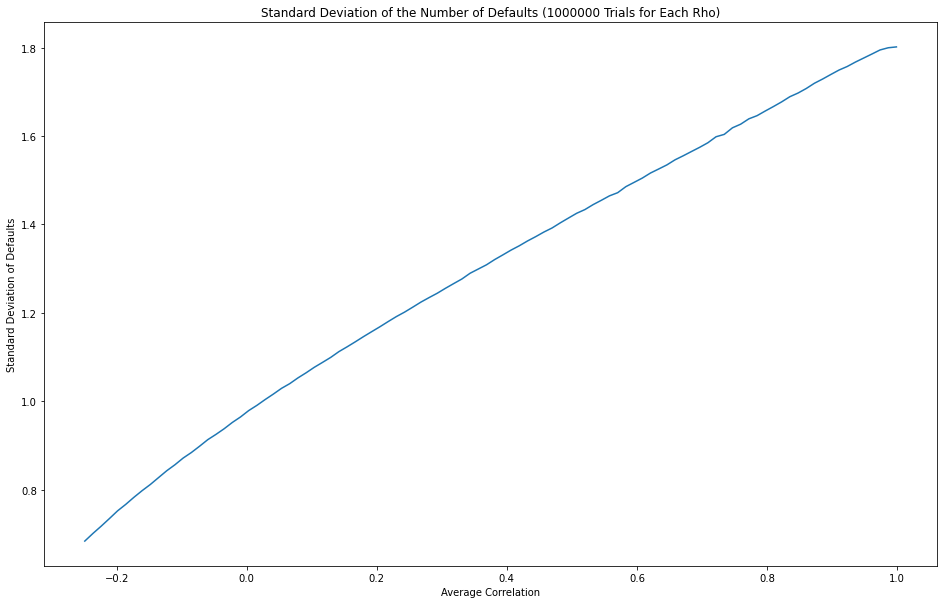

In [4]:
rhos = np.linspace(-0.249, 0.999, 100)
stds = np.zeros(rhos.shape)
N = 1000000

for i, rho in enumerate(rhos):
    Corr = np.ones((5,5))*rho + np.eye(5)*(1-rho)
    sim = simulate_defaults(PDz, Corr, N)
    defaults = sim.sum(axis=1)
    stds[i] = np.std(defaults, ddof=1)

plt.plot(rhos, stds)
plt.title(f"Standard Deviation of the Number of Defaults ({N} Trials for Each Rho)")
plt.xlabel("Average Correlation")
plt.ylabel("Standard Deviation of Defaults")
plt.show()

# Question 3

Assume the following portfolio. Exposures are stated in USD. Questions can be answered by simulation or calculation; each method provides a check on the other.

What are the values of these four quantities?

I will solve these analytically.

In [5]:
data = np.array([[0.1, 0.1, 700],
                 [0.2, 0.2, 600],
                 [0.3, 0.3, 500],
                 [0.4, 0.4, 400],
                 [0.5, 0.5, 300],
                 [0.4, 0.6, 200],
                 [0.5, 0.7, 100]])

PD =   data[:,0]
PDz =  norm.ppf(PD)
ELGD = data[:,1]
Exp =  data[:,2]

Corr = np.array([[1,    0.15, 0.2,  0.25, 0.3],
                 [0.15, 1,    0.25, 0.3,  0.35],
                 [0.2,  0.25, 1,    0.35, 0.4],
                 [0.25, 0.3,  0.35, 1,    0.45],
                 [0.3,  0.35, 0.4,  0.45, 1]])

def pd_from_copula(zs, Corr):
    """Uses Z-scores and Corr to determine the probability of default 
    of all assets modeled using an n-Copula"""
    copula = multivariate_normal(mean=np.zeros(zs.shape[0]), cov=Corr)
    return copula.cdf(zs)

* $\mathbb{P}[ D_4 = 1, D_5 = 1]$? (What is PDJ for these two firms?)

In [6]:
PD_45 = pd_from_copula(PDz[3:5], Corr[3:,3:])
print(f"Joint Probability = {PD_45:.2g}")

Joint Probability = 0.27


* $\mathbb{P}[ D_4 = 1, D_5 = 1| D_3 =1 ]$? (That is, what is the probability that both Firm 4 and Firm 5 default, given that Firm 3 defaults?)

In [7]:
PD_345 = pd_from_copula(PDz[2:5], Corr[2:,2:])
PD_3 = pd_from_copula(PDz[2:3], Corr[2,2])

PD_45_F3 = PD_345 / PD_3
print(f"Conditional Probability = {PD_45_F3:.2g}")

Conditional Probability = 0.44


* What is the portfolio expected loss rate as a fraction of the \\$2800 exposure?

$$\begin{aligned}
    D_i &= \text{Vector of default flags} \\
    \Omega &= \text{Sample space of all default events; } \forall i: D_i \in \Omega \\
    N(D_i) &= \text{Notional loss on default events} \\
        &= ELGD \cdot Exposure \\
    \mathbb{P}(D_i) &= \text{Probability of default event occuring} \\
        &= \int_{D_i} \frac{1}{\sqrt{|2\pi \Sigma|}} e^{-\frac{1}{2}x'\Sigma^{-1} x} \\
    \mathbb{E}_\Omega(N) &= \text{Expected notional loss across all default events} \\
        &= \sum_{D_i \in \Omega} \mathbb{P}(D_i) N(D_i)
\end{aligned}$$

In [8]:
default_flags = np.unique(np.array(list(permutations([-1]*5+[1]*5)))[:,:5], axis=0)

notional = ELGD*Exp
notional[3] += notional[5]
notional[4] += notional[6]
notional = -notional[:5]

ps = []
notELGD = []

for event in default_flags:
    lower = np.array([-np.inf if d==1 else PDz[i] for i, d in enumerate(event)])
    upper = np.array([np.inf if d==-1 else PDz[i] for i, d in enumerate(event)])
    p = mvnun(lower, upper, np.zeros(lower.shape[0]), Corr)[0]
    ps.append(p)
    
    nE = notional @ np.maximum(event,0)
    notELGD.append(nE)

cols = ["D1", "D2", "D3", "D4", "D5", "Prob", "NotionalELGD"]

ELGDdf = pd.DataFrame(np.concatenate([default_flags, 
                np.array([ps, notELGD]).T], axis=1), columns=cols)
ELGDdf.T

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
D1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
D2,-1,-1,-1,-1,-1,-1,-1,-1,1,1,...,-1,-1,1,1,1,1,1,1,1,1
D3,-1,-1,-1,-1,1,1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,1,1
D4,-1,-1,1,1,-1,-1,1,1,-1,-1,...,1,1,-1,-1,1,1,-1,-1,1,1
D5,-1,1,-1,1,-1,1,-1,1,-1,1,...,-1,1,-1,1,-1,1,-1,1,-1,1
Prob,0.27,0.11,0.071,0.085,0.046,0.048,0.025,0.067,0.028,0.026,...,0.0028,0.015,0.0017,0.0032,0.0013,0.0066,0.00064,0.0027,0.0009,0.011
NotionalELGD,0,-2.2e+02,-2.8e+02,-5e+02,-1.5e+02,-3.7e+02,-4.3e+02,-6.5e+02,-1.2e+02,-3.4e+02,...,-5e+02,-7.2e+02,-1.9e+02,-4.1e+02,-4.7e+02,-6.9e+02,-3.4e+02,-5.6e+02,-6.2e+02,-8.4e+02


In [9]:
totExp = Exp @ np.ones(Exp.shape[0])
notExpLGD = ELGDdf["Prob"] @ ELGDdf["NotionalELGD"]
lossFrac = notExpLGD / totExp
print(f"Expected Loss Rate = {lossFrac:.2g}")

Expected Loss Rate = -0.11


* What is the correlation between $D_3$ and $D_4$?

$$\begin{aligned}
    Dcorr[D_1, D_2] &= \frac{Cov[D_1, D_2]}{\sqrt{Var[D_1] Var[D_2]}} \\
        &= \frac{PDJ- PD_1 PD_2}{\sqrt{PD_1(1-PD_1)PD_2(1-PD_2)}}
\end{aligned}$$

In [10]:
def dcorr(pd_i, pd_j, joint):
    """Default Correlation from default probabilities"""
    return (joint - pd_i*pd_j) / (pd_i*(1-pd_i)*pd_j*(1-pd_j))**0.5

PD_34 = pd_from_copula(PDz[2:4], Corr[2:4,2:4])
DCorr_34 = dcorr(PD[2], PD[3], PD_34)
print(f"Default Correlation = {DCorr_34:.2g}")

Default Correlation = 0.22


# Question 4

Simulate for 10,000 runs the default rate of the portfolio of Question 3 and plot a histogram. Separately, simulate the loss rate (total loss / total exposure) assuming that every LGD equals its expected value. Show a scatter plot of each possible loss rate (horizontal) and the number of simulation runs the loss is experienced (vertical). Summarize all outcomes in a histogram with loss rates separated into bins of width 2%.

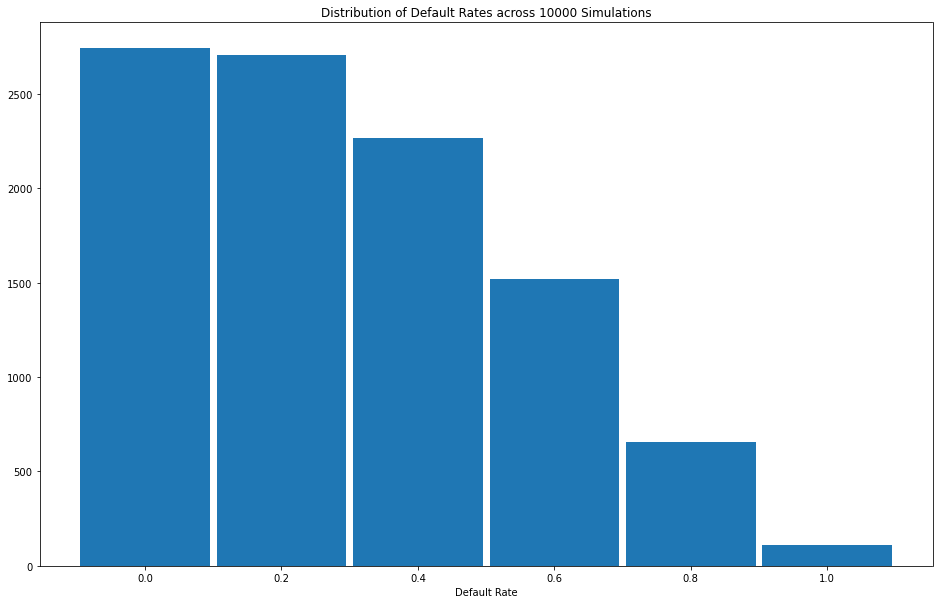

In [11]:
N = 10000

sim = simulate_defaults(PDz[:5], Corr, N)
defaults = sim.sum(axis=1)
plt.hist((defaults/5), bins=np.linspace(-0.1, 1.1, 7), rwidth=0.95)
plt.xlabel("Default Rate")
plt.title(f"Distribution of Default Rates across {N} Simulations")
plt.show()

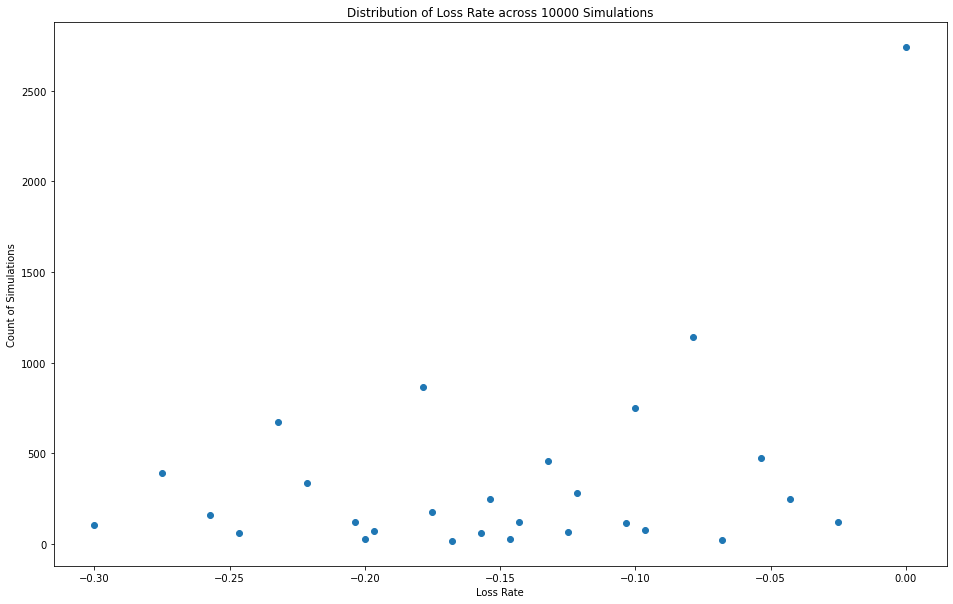

In [12]:
lossRates = sim.astype(int) @ notional / totExp
lrs, cts = np.unique(lossRates ,return_counts=True)
plt.scatter(lrs, cts)
plt.title(f"Distribution of Loss Rate across {N} Simulations")
plt.xlabel("Loss Rate")
plt.ylabel("Count of Simulations")
plt.show()

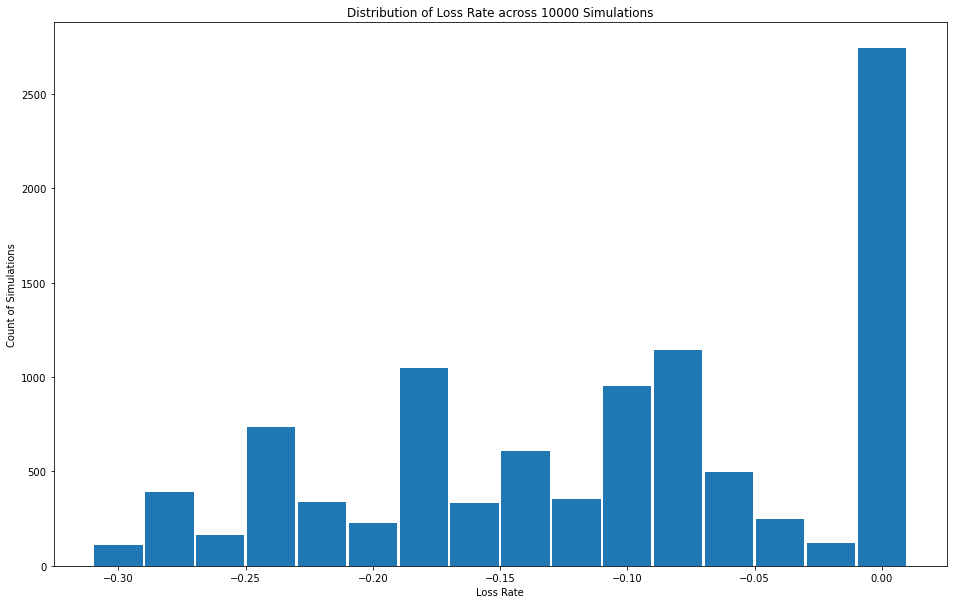

In [13]:
plt.hist(lossRates, bins=np.arange(-0.31, 0.03, 0.02), rwidth=0.95)
plt.title(f"Distribution of Loss Rate across {N} Simulations")
plt.xlabel("Loss Rate")
plt.ylabel("Count of Simulations")
plt.show()